# Credit Card Customer Segmentation

We are data scientists working for a credit card company. Our dataset contains information about the company’s clients and we're asked to help segment them into different groups in order to apply different business strategies for each type of customer.

The data engineering team has already cleaned most of the data so we can focus on building the best possible model to segment the data. Also, in a planning meeting with the Data Science coordinator, it was decided that we should use the K-means algorithm to segment the data.

### Deliverables
The company expects to receive a group for each client and an explanation of the characteristics of each group and the main points that make them different.

In [63]:
# Import everything
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

np.random.seed(42)

sns.set_style('whitegrid')

# Read in the dataset
customers = pd.read_csv('customer_segmentation.csv')

### Familiarise ourselves with the dataset

In [64]:
# Size
customers.shape

(10127, 14)

In [65]:
# Columns, null values, types
customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 14 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   customer_id               10127 non-null  int64  
 1   age                       10127 non-null  int64  
 2   gender                    10127 non-null  object 
 3   dependent_count           10127 non-null  int64  
 4   education_level           10127 non-null  object 
 5   marital_status            10127 non-null  object 
 6   estimated_income          10127 non-null  int64  
 7   months_on_book            10127 non-null  int64  
 8   total_relationship_count  10127 non-null  int64  
 9   months_inactive_12_mon    10127 non-null  int64  
 10  credit_limit              10127 non-null  float64
 11  total_trans_amount        10127 non-null  int64  
 12  total_trans_count         10127 non-null  int64  
 13  avg_utilization_ratio     10127 non-null  float64
dtypes: flo

In [66]:
customers.head()

,customer_id,age,gender,dependent_count,education_level,marital_status,estimated_income,months_on_book,total_relationship_count,months_inactive_12_mon,credit_limit,total_trans_amount,total_trans_count,avg_utilization_ratio
0,768805383,45,M,3,High School,Married,69000,39,5,1,12691.0,1144,42,0.061
1,818770008,49,F,5,Graduate,Single,24000,44,6,1,8256.0,1291,33,0.105
2,713982108,51,M,3,Graduate,Married,93000,36,4,1,3418.0,1887,20,0.000
3,769911858,40,F,4,High School,Unknown,37000,34,3,4,3313.0,1171,20,0.760
4,709106358,40,M,3,Uneducated,Married,65000,21,5,1,4716.0,816,28,0.000


In [67]:
customers['education_level'].value_counts()

Graduate         3685
High School      2351
Uneducated       1755
College          1192
Post-Graduate     616
Doctorate         528
Name: education_level, dtype: int64

In [68]:
customers['marital_status'].value_counts()

Married     4687
Single      3943
Unknown      749
Divorced     748
Name: marital_status, dtype: int64

There are three non-numeric columns:
1. Gender: Turn 'M' and 'F' into 0 and 1. 
2. Education Level: Maybe we can split it into dummy columns.
3. Marital Status: Again, maybe we can split it into dummy columns. 

## Cleaning

In [69]:
# Turn Gender into numerics
customers['gender'] = customers['gender'].apply(lambda x: 0 if x=='M' else 1)

In [70]:
# Replace education levels with numbers
customers['education'] = customers['education_level'].replace({'Uneducated':0,'High School':1,'College':2,'Graduate':3,'Post-Graduate':4,'Doctorate':5})

In [71]:
# Turn Marital Status into dummy columns
ms_dummies = pd.get_dummies(customers['marital_status'])
customers = pd.concat([customers, ms_dummies], axis=1)

In [72]:
exp_customers = customers.drop(['education_level','marital_status'],axis=1)
exp_customers

,customer_id,age,gender,dependent_count,estimated_income,months_on_book,total_relationship_count,months_inactive_12_mon,credit_limit,total_trans_amount,total_trans_count,avg_utilization_ratio,education,Divorced,Married,Single,Unknown
0,768805383,45,0,3,69000,39,5,1,12691.0,1144,42,0.061,1,0,1,0,0
1,818770008,49,1,5,24000,44,6,1,8256.0,1291,33,0.105,3,0,0,1,0
2,713982108,51,0,3,93000,36,4,1,3418.0,1887,20,0.000,3,0,1,0,0
3,769911858,40,1,4,37000,34,3,4,3313.0,1171,20,0.760,1,0,0,0,1
4,709106358,40,0,3,65000,21,5,1,4716.0,816,28,0.000,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10122,772366833,50,0,2,51000,40,3,2,4003.0,15476,117,0.462,3,0,0,1,0
10123,710638233,41,0,2,40000,25,4,2,4277.0,8764,69,0.511,3,1,0,0,0
10124,716506083,44,1,1,33000,36,5,3,5409.0,10291,60,0.000,1,0,1,0,0
10125,717406983,30,0,2,47000,36,4,3,5281.0,8395,62,0.000,3,0,0,0,1


### Further Data Exploration

<AxesSubplot:>

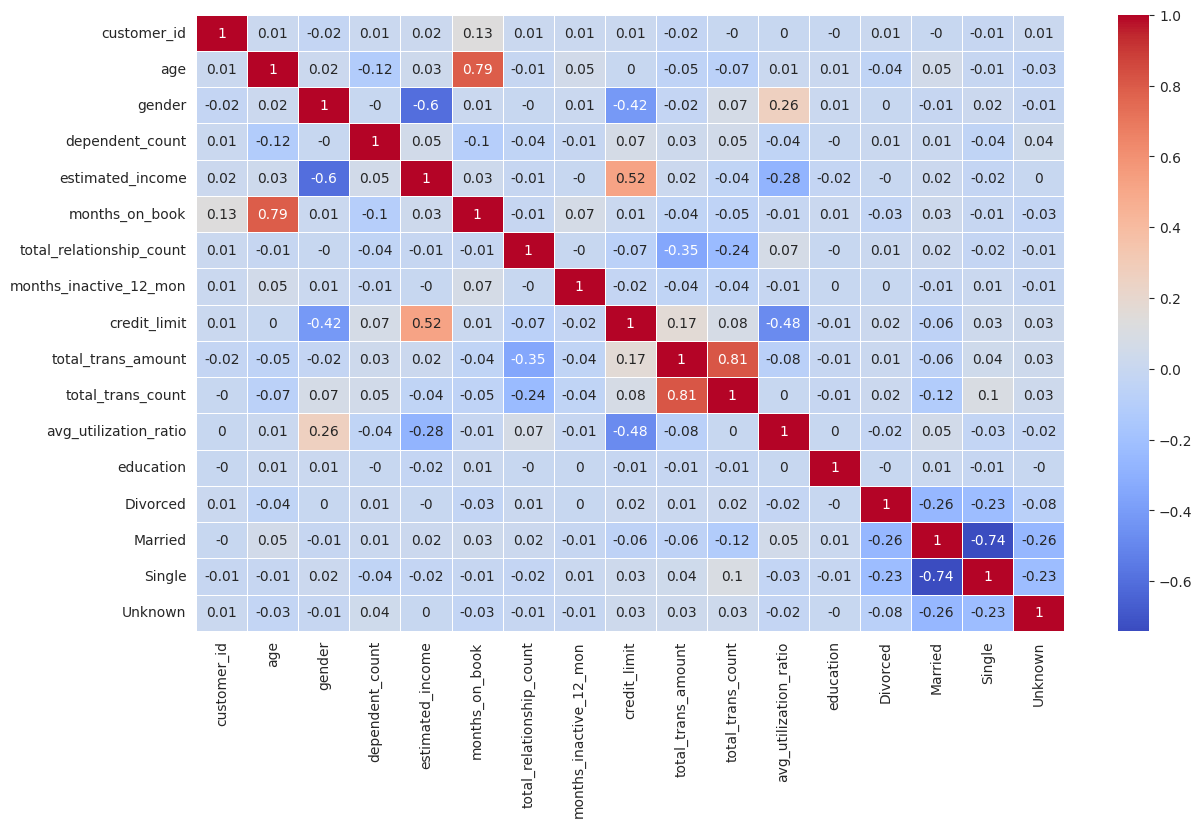

In [116]:
corrs = exp_customers.corr()

plt.figure(figsize=(14, 8))
sns.heatmap(round(corrs,2), 
            xticklabels=corrs.columns, 
            yticklabels=corrs.columns,
            cmap='coolwarm', # Choose a colormap that represents the correlation scale
            annot=True, # Show correlation values
            linewidths=.5) # Line widths between squares


There are strong (>0.6 (abs)) correlations as follows:
age - months_on_book
gender - income
total_trans_amount - total_trans_count

There are moderate (0.3 - 0.6 (abs)) correlations as follows:
gender - estimated_income
gender - credit_limit
gender - avg_utilization_ratio
estimated_income - avg_utilization_rate
total_relationship_count - total_trans_amount
credit_limit - estimated income
credit_limit - avg_utilization_ratio

The dummy demographics correlate within their area but we can ignore those. 

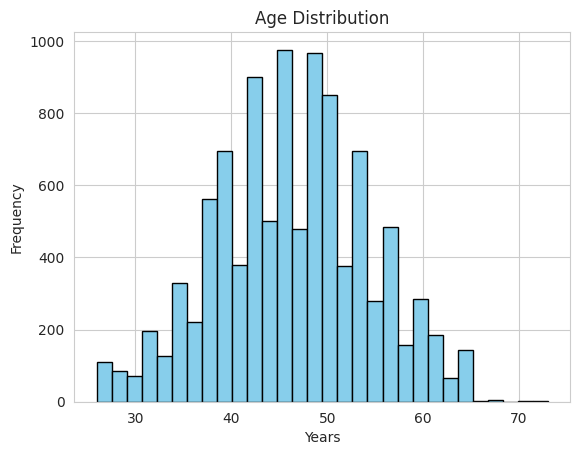

In [74]:
# Explore some distributions
plt.hist(exp_customers['age'], bins=30, color='skyblue', edgecolor='black')
plt.xlabel('Years')
plt.ylabel('Frequency')
plt.title('Age Distribution')
plt.show()

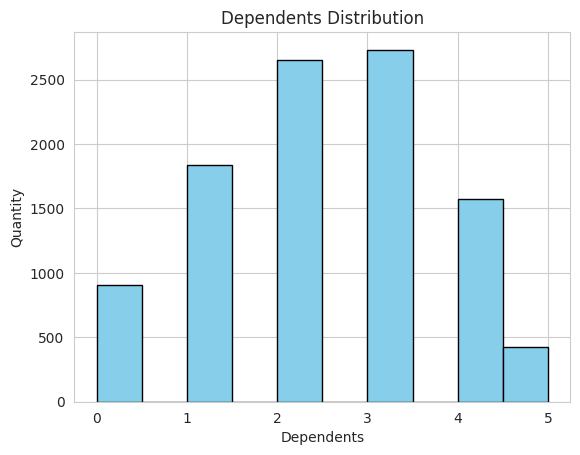

In [75]:
plt.hist(exp_customers['dependent_count'], color='skyblue', edgecolor='black')
plt.xlabel('Dependents')
plt.ylabel('Quantity')
plt.title('Dependents Distribution')
plt.show()

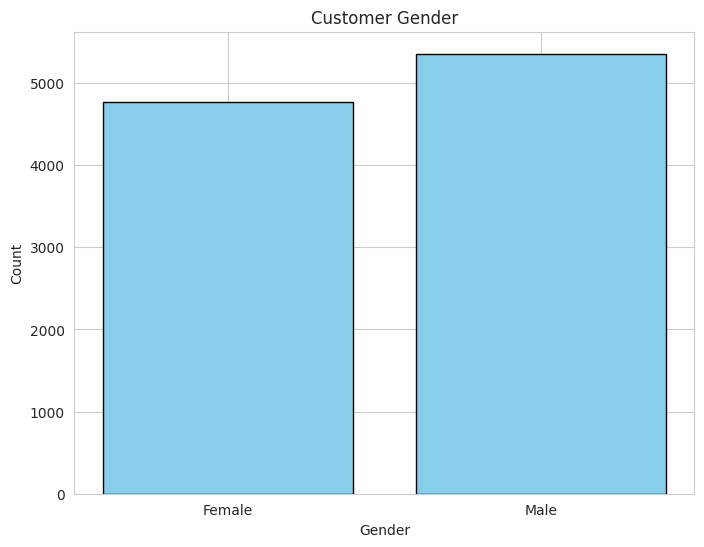

In [76]:
gen_counts = customers['gender'].value_counts()

# Plot
plt.figure(figsize=(8, 6)) 
plt.bar(gen_counts.index, gen_counts.values, color='skyblue', edgecolor='black')

plt.xlabel('Gender')
plt.ylabel('Count')
plt.title('Customer Gender')
plt.xticks(ticks=range(len(gen_counts.index)), labels=['Male' if x == 0 else 'Female' for x in gen_counts.index])

plt.show()

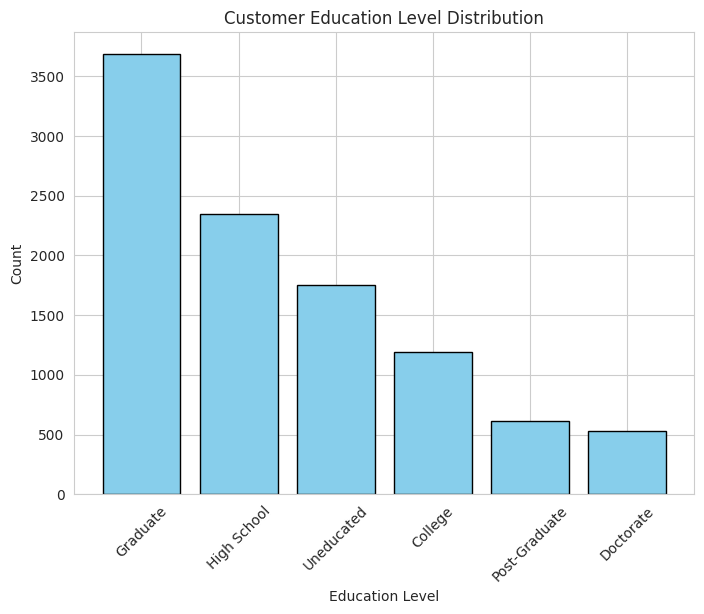

In [77]:
edu_counts = customers['education_level'].value_counts()

# Plot
plt.figure(figsize=(8, 6)) 
plt.bar(edu_counts.index, edu_counts.values, color='skyblue', edgecolor='black')

plt.xlabel('Education Level')
plt.ylabel('Count')
plt.title('Customer Education Level Distribution')
plt.xticks(rotation=45)
plt.show()

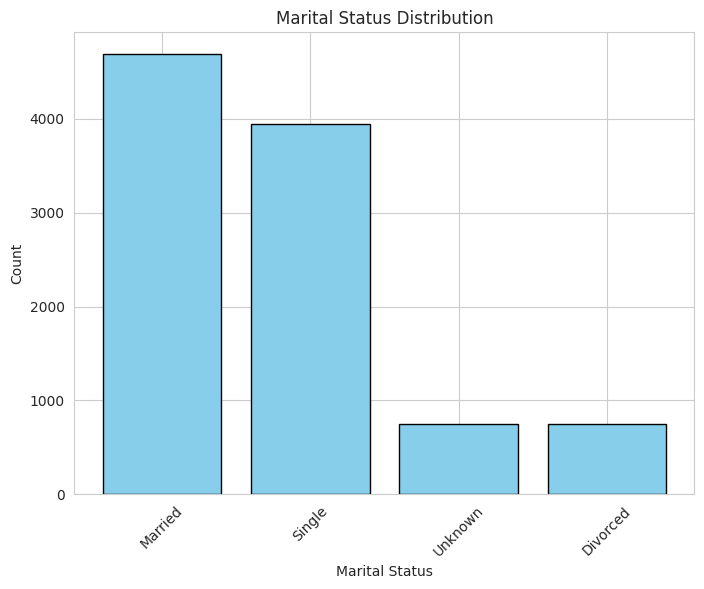

In [78]:
marital_counts = customers['marital_status'].value_counts()

# Plot
plt.figure(figsize=(8, 6)) 
plt.bar(marital_counts.index, marital_counts.values, color='skyblue', edgecolor='black')

plt.xlabel('Marital Status')
plt.ylabel('Count')
plt.title('Marital Status Distribution')
plt.xticks(rotation=45)
plt.show()

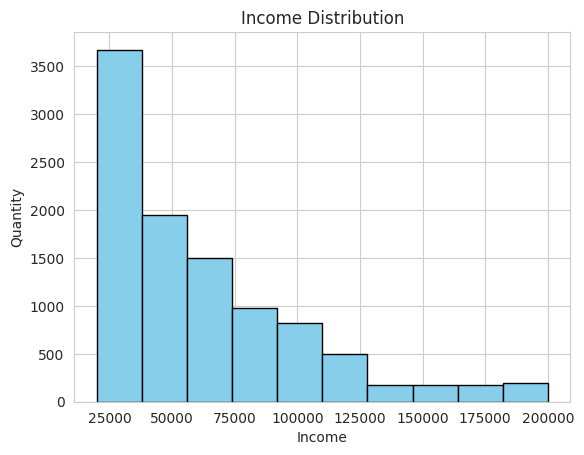

In [79]:
plt.hist(exp_customers['estimated_income'], color='skyblue', edgecolor='black')
plt.xlabel('Income')
plt.ylabel('Quantity')
plt.title('Income Distribution')
plt.show()

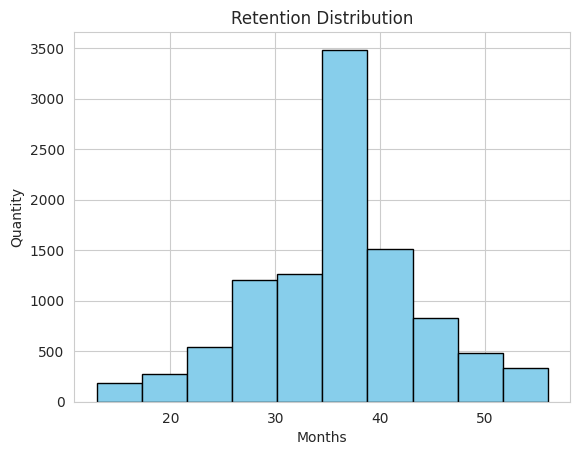

In [80]:
plt.hist(exp_customers['months_on_book'], color='skyblue', edgecolor='black')
plt.xlabel('Months')
plt.ylabel('Quantity')
plt.title('Retention Distribution')
plt.show()

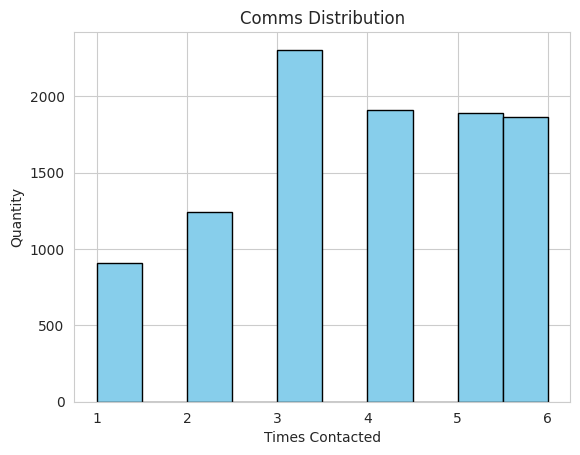

In [81]:
plt.hist(exp_customers['total_relationship_count'], color='skyblue', edgecolor='black')
plt.xlabel('Times Contacted')
plt.ylabel('Quantity')
plt.title('Comms Distribution')
plt.show()

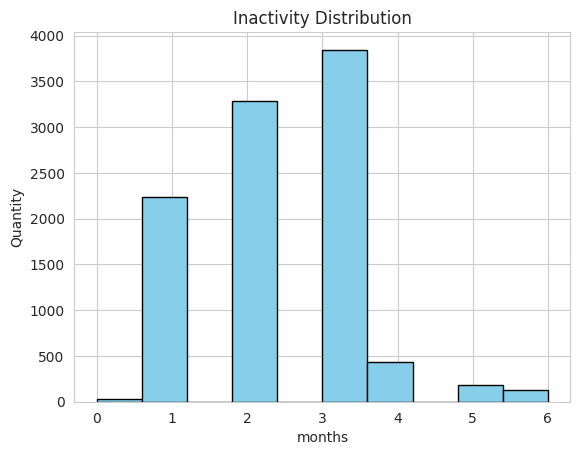

In [82]:
plt.hist(exp_customers['months_inactive_12_mon'], color='skyblue', edgecolor='black')
plt.xlabel('months')
plt.ylabel('Quantity')
plt.title('Inactivity Distribution')
plt.show()

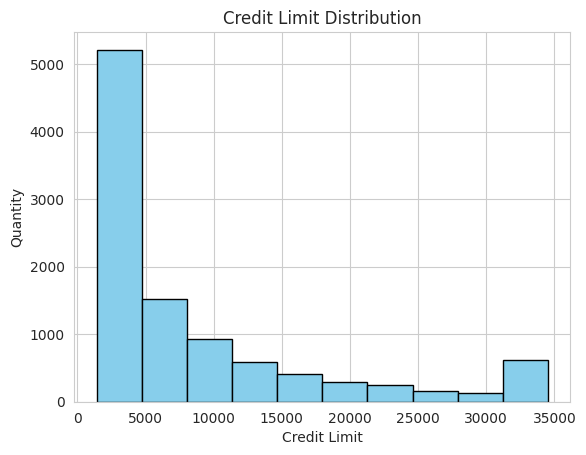

In [83]:
plt.hist(exp_customers['credit_limit'], color='skyblue', edgecolor='black')
plt.xlabel('Credit Limit')
plt.ylabel('Quantity')
plt.title('Credit Limit Distribution')
plt.show()

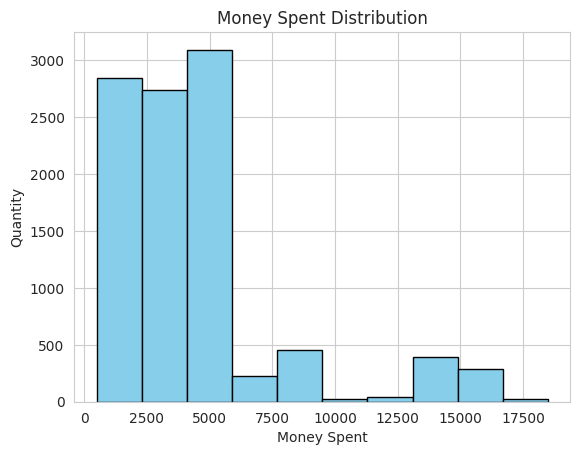

In [84]:
plt.hist(exp_customers['total_trans_amount'], color='skyblue', edgecolor='black')
plt.xlabel('Money Spent')
plt.ylabel('Quantity')
plt.title('Money Spent Distribution')
plt.show()

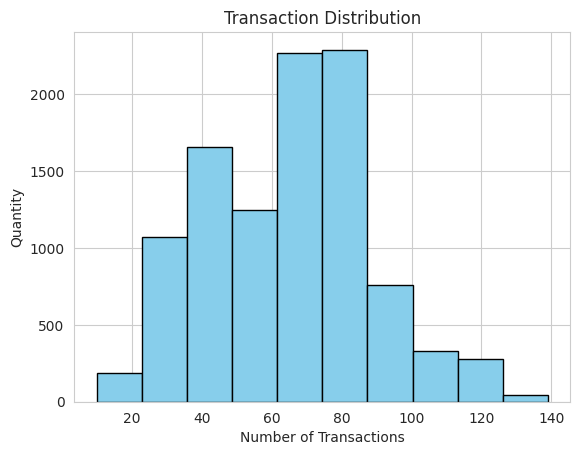

In [85]:
plt.hist(exp_customers['total_trans_count'], color='skyblue', edgecolor='black')
plt.xlabel('Number of Transactions')
plt.ylabel('Quantity')
plt.title('Transaction Distribution')
plt.show()

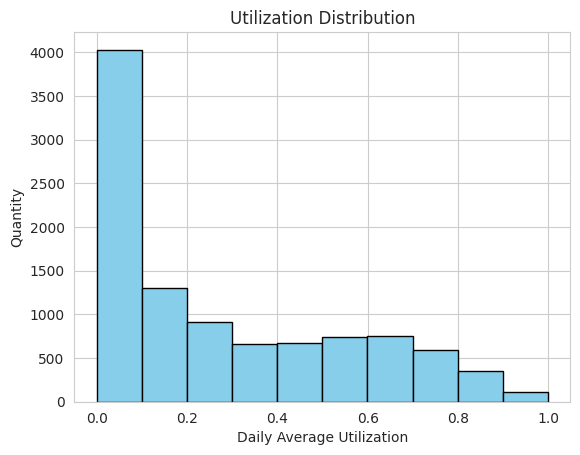

,customer_id,age,gender,dependent_count,estimated_income,months_on_book,total_relationship_count,months_inactive_12_mon,credit_limit,total_trans_amount,total_trans_count,avg_utilization_ratio,education,Divorced,Married,Single,Unknown
0,768805383,45,0,3,69000,39,5,1,12691.0,1144,42,0.061,1,0,1,0,0
1,818770008,49,1,5,24000,44,6,1,8256.0,1291,33,0.105,3,0,0,1,0
2,713982108,51,0,3,93000,36,4,1,3418.0,1887,20,0.000,3,0,1,0,0
3,769911858,40,1,4,37000,34,3,4,3313.0,1171,20,0.760,1,0,0,0,1
4,709106358,40,0,3,65000,21,5,1,4716.0,816,28,0.000,0,0,1,0,0


In [86]:
plt.hist(exp_customers['avg_utilization_ratio'], color='skyblue', edgecolor='black')
plt.xlabel('Daily Average Utilization')
plt.ylabel('Quantity')
plt.title('Utilization Distribution')
plt.show()
exp_customers.head()

## Scaling the Data

In [87]:
exp_no_id = exp_customers.drop('customer_id',axis=1)

In [88]:
scaler = StandardScaler()
scaler.fit(exp_no_id)
exp_scaled = scaler.transform(exp_no_id)
exp_scaled[:5]

array([[-0.16540558, -1.05995565,  0.50336813,  0.1758098 ,  0.38462088,
         0.76394261, -1.32713603,  0.4466219 , -0.95970657, -0.97389518,
        -0.77588223, -0.75221102, -0.2824051 ,  1.07733799, -0.79850685,
        -0.28260887],
       [ 0.33357038,  0.9434357 ,  2.04319867, -0.96716585,  1.01071482,
         1.40730617, -1.32713603, -0.04136665, -0.91643261, -1.35734038,
        -0.61627565,  0.66278684, -0.2824051 , -0.92821381,  1.2523374 ,
        -0.28260887],
       [ 0.58305837, -1.05995565,  0.50336813,  0.78539682,  0.00896451,
         0.12057905, -1.32713603, -0.5736978 , -0.74098169, -1.91120566,
        -0.99715499,  0.66278684, -0.2824051 ,  1.07733799, -0.79850685,
        -0.28260887],
       [-0.78912553,  0.9434357 ,  1.2732834 , -0.63697289, -0.24147306,
        -0.52278451,  1.64147829, -0.58525108, -0.95175829, -1.91120566,
         1.75968594, -0.75221102, -0.2824051 , -0.92821381, -0.79850685,
         3.53845931],
       [-0.78912553, -1.05995565,  0

## Choosing K

Now our dataset is ready for machine learning. The next step is to decide the best number of clusters to use in the segmentation according to the inertia metric.

We'll have to create several models and compute the inertia from each of them. Then, we'll be able to plot the Elbow Curve and decide the number of clusters we'll use to segment the customers. Once we do all that, we can perform the real clusterization.

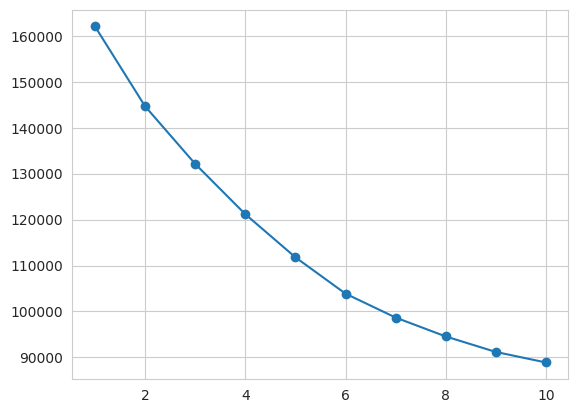

In [89]:
exp_scal = pd.DataFrame(exp_scaled)
inertias = []
for i in range(1,11):
    model = KMeans(n_clusters=i)
    clusters = model.fit_predict(exp_scal)
    inertias.append(model.inertia_)
plt.plot(range(1,11),inertias,marker='o')
plt.show()

There is no sharp "elbow" but the drop in inertia seems to reduce from 6 clusters so we'll run with 6 clusters. 

In [90]:
model_b = KMeans(n_clusters=6,random_state=50)
clusters = model_b.fit_predict(exp_scal)
print(clusters)

[1 4 1 ... 5 0 5]


##  Analyzing Results

All that's left now is to analyze the results. We need to see how the variables used in the clusterization differ from cluster to cluster in order better explain what each cluster represents.

We will note the most important characteristics of each cluster and how they can impact the business and marketing strategies for each type of customer.

In [91]:
customers['CLUSTER'] = clusters + 1
clus = customers['CLUSTER'].value_counts()
sort_clus = clus.sort_index()
sort_clus

1     740
2    1638
3     738
4     867
5    2883
6    3261
Name: CLUSTER, dtype: int64

([<matplotlib.axis.XTick at 0x7fc1600e4850>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

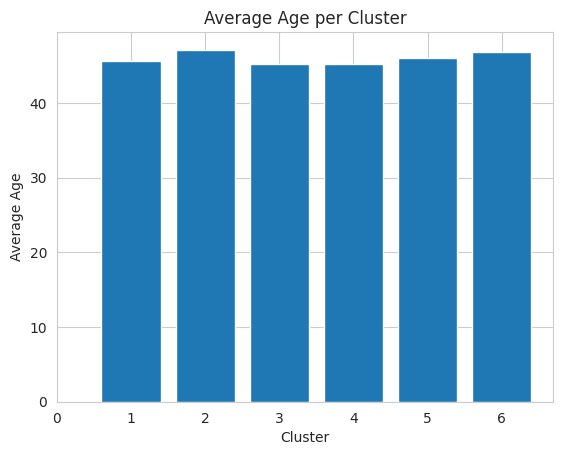

In [92]:
age = customers.groupby('CLUSTER')['age'].mean()
plt.bar(age.index, age.values,)
plt.xlabel('Cluster')
plt.ylabel('Average Age')
plt.title('Average Age per Cluster')
plt.xticks(range(0, 7))

In [93]:
age

CLUSTER
1    45.612162
2    47.139194
3    45.215447
4    45.283737
5    46.062435
6    46.840846
Name: age, dtype: float64

In [94]:
gen = customers.groupby('CLUSTER')['gender'].sum()
gen
female_prop = round(gen/sort_clus*100,1)
female_prop

CLUSTER
1    51.4
2     3.5
3    54.1
4    34.1
5    68.2
6    69.3
dtype: float64

In [95]:
male_prop = round(100-female_prop,1)
male_prop

CLUSTER
1    48.6
2    96.5
3    45.9
4    65.9
5    31.8
6    30.7
dtype: float64

(array([0, 1, 2, 3, 4, 5]),
 [Text(0, 0, '1'),
  Text(1, 0, '2'),
  Text(2, 0, '3'),
  Text(3, 0, '4'),
  Text(4, 0, '5'),
  Text(5, 0, '6')])

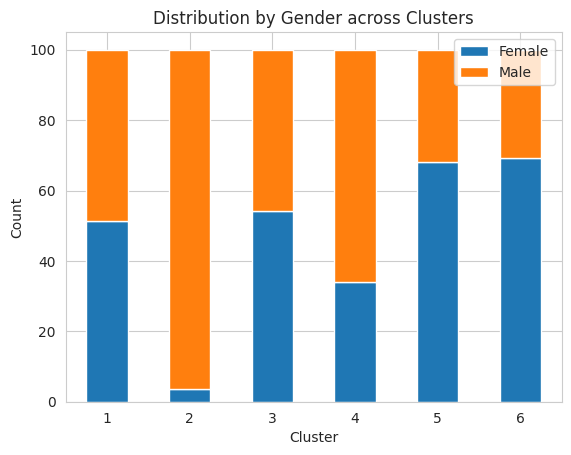

In [96]:
gender_splits = pd.concat([female_prop, male_prop], axis=1, keys=['Female', 'Male'])
gender_splits.plot(kind='bar', stacked=True)
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.title('Distribution by Gender across Clusters')
plt.xticks(rotation=0)  # keeps the x-axis labels horizontal

In [97]:
gender_splits

,Female,Male
CLUSTER,,
1,51.4,48.6
2,3.5,96.5
3,54.1,45.9
4,34.1,65.9
5,68.2,31.8
6,69.3,30.7


([<matplotlib.axis.XTick at 0x7fc143f4cf40>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

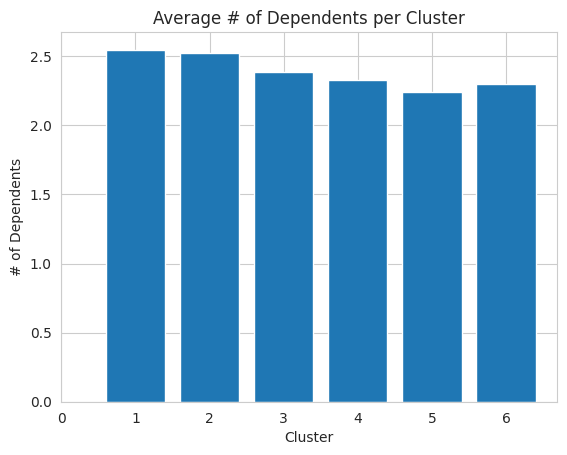

In [98]:
deps = customers.groupby('CLUSTER')['dependent_count'].mean()
plt.bar(deps.index, deps.values,)
plt.xlabel('Cluster')
plt.ylabel('# of Dependents')
plt.title('Average # of Dependents per Cluster')
plt.xticks(range(0, 7))

([<matplotlib.axis.XTick at 0x7fc143f9bd90>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

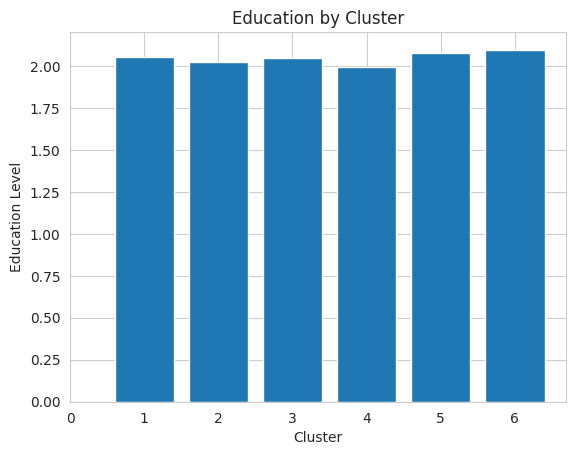

In [99]:
educ = customers.groupby('CLUSTER')['education'].mean()
plt.bar(educ.index, educ.values,)
plt.xlabel('Cluster')
plt.ylabel('Education Level')
plt.title('Education by Cluster')
plt.xticks(range(0, 7))

([<matplotlib.axis.XTick at 0x7fc143e20040>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

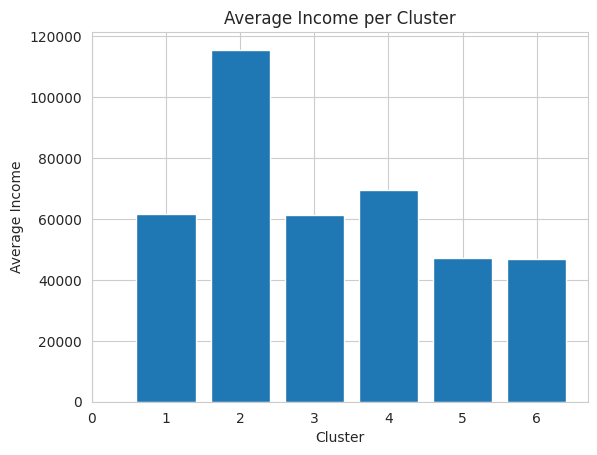

In [100]:
inc = customers.groupby('CLUSTER')['estimated_income'].mean()
plt.bar(inc.index, inc.values,)
plt.xlabel('Cluster')
plt.ylabel('Average Income')
plt.title('Average Income per Cluster')
plt.xticks(range(0, 7))

([<matplotlib.axis.XTick at 0x7fc143e77250>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

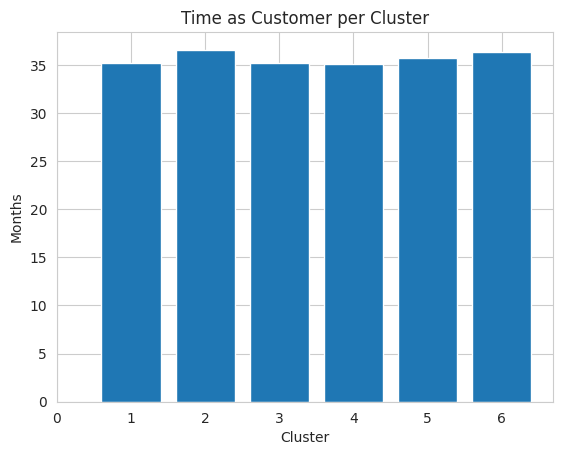

In [101]:
time = customers.groupby('CLUSTER')['months_on_book'].mean()
plt.bar(time.index, time.values,)
plt.xlabel('Cluster')
plt.ylabel('Months')
plt.title('Time as Customer per Cluster')
plt.xticks(range(0, 7))

([<matplotlib.axis.XTick at 0x7fc143ee6e60>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

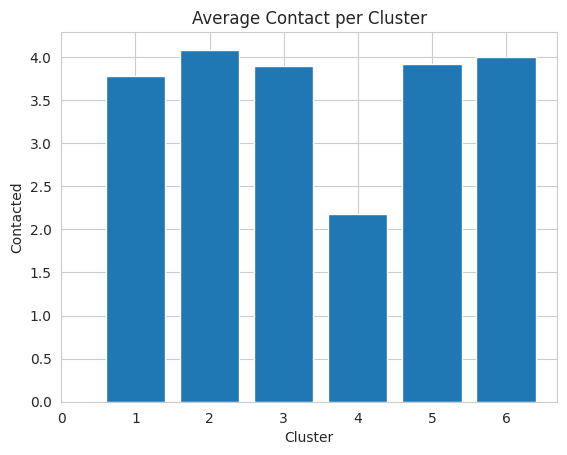

In [102]:
rel = customers.groupby('CLUSTER')['total_relationship_count'].mean()
plt.bar(rel.index, rel.values,)
plt.xlabel('Cluster')
plt.ylabel('Contacted')
plt.title('Average Contact per Cluster')
plt.xticks(range(0, 7))

,customer_id,age,gender,dependent_count,education_level,marital_status,estimated_income,months_on_book,total_relationship_count,months_inactive_12_mon,credit_limit,total_trans_amount,total_trans_count,avg_utilization_ratio,education,Divorced,Married,Single,Unknown,CLUSTER
0,768805383,45,0,3,High School,Married,69000,39,5,1,12691.0,1144,42,0.061,1,0,1,0,0,2
1,818770008,49,1,5,Graduate,Single,24000,44,6,1,8256.0,1291,33,0.105,3,0,0,1,0,5
2,713982108,51,0,3,Graduate,Married,93000,36,4,1,3418.0,1887,20,0.000,3,0,1,0,0,2
3,769911858,40,1,4,High School,Unknown,37000,34,3,4,3313.0,1171,20,0.760,1,0,0,0,1,1
4,709106358,40,0,3,Uneducated,Married,65000,21,5,1,4716.0,816,28,0.000,0,0,1,0,0,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10122,772366833,50,0,2,Graduate,Single,51000,40,3,2,4003.0,15476,117,0.462,3,0,0,1,0,4
10123,710638233,41,0,2,Graduate,Divorced,40000,25,4,2,4277.0,8764,69,0.511,3,1,0,0,0,3
10124,716506083,44,1,1,High School,Married,33000,36,5,3,5409.0,10291,60,0.000,1,0,1,0,0,6
10125,717406983,30,0,2,Graduate,Unknown,47000,36,4,3,5281.0,8395,62,0.000,3,0,0,0,1,1


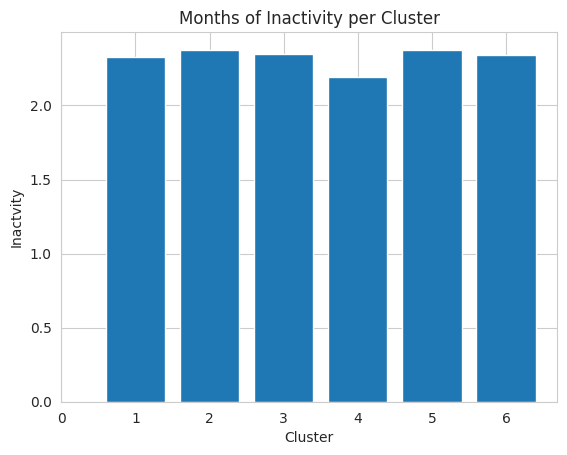

In [103]:
inac = customers.groupby('CLUSTER')['months_inactive_12_mon'].mean()
plt.bar(inac.index, inac.values,)
plt.xlabel('Cluster')
plt.ylabel('Inactvity')
plt.title('Months of Inactivity per Cluster')
plt.xticks(range(0, 7))
customers

In [104]:
customers

,customer_id,age,gender,dependent_count,education_level,marital_status,estimated_income,months_on_book,total_relationship_count,months_inactive_12_mon,credit_limit,total_trans_amount,total_trans_count,avg_utilization_ratio,education,Divorced,Married,Single,Unknown,CLUSTER
0,768805383,45,0,3,High School,Married,69000,39,5,1,12691.0,1144,42,0.061,1,0,1,0,0,2
1,818770008,49,1,5,Graduate,Single,24000,44,6,1,8256.0,1291,33,0.105,3,0,0,1,0,5
2,713982108,51,0,3,Graduate,Married,93000,36,4,1,3418.0,1887,20,0.000,3,0,1,0,0,2
3,769911858,40,1,4,High School,Unknown,37000,34,3,4,3313.0,1171,20,0.760,1,0,0,0,1,1
4,709106358,40,0,3,Uneducated,Married,65000,21,5,1,4716.0,816,28,0.000,0,0,1,0,0,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10122,772366833,50,0,2,Graduate,Single,51000,40,3,2,4003.0,15476,117,0.462,3,0,0,1,0,4
10123,710638233,41,0,2,Graduate,Divorced,40000,25,4,2,4277.0,8764,69,0.511,3,1,0,0,0,3
10124,716506083,44,1,1,High School,Married,33000,36,5,3,5409.0,10291,60,0.000,1,0,1,0,0,6
10125,717406983,30,0,2,Graduate,Unknown,47000,36,4,3,5281.0,8395,62,0.000,3,0,0,0,1,1


([<matplotlib.axis.XTick at 0x7fc143d9f2e0>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

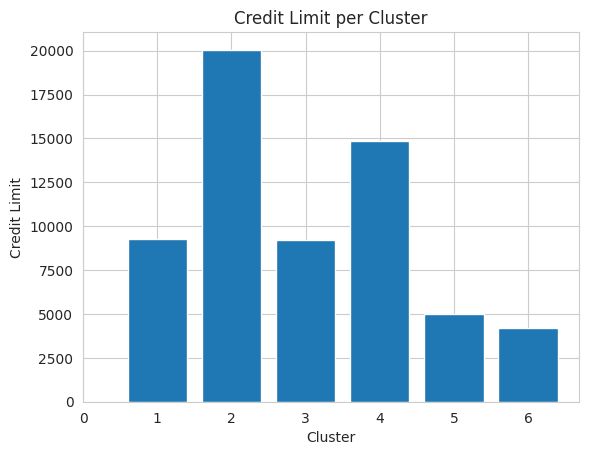

In [105]:
credit_limit = customers.groupby('CLUSTER')['credit_limit'].mean()
plt.bar(credit_limit.index, credit_limit.values,)
plt.xlabel('Cluster')
plt.ylabel('Credit Limit')
plt.title('Credit Limit per Cluster')
plt.xticks(range(0, 7))

([<matplotlib.axis.XTick at 0x7fc143c0e740>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

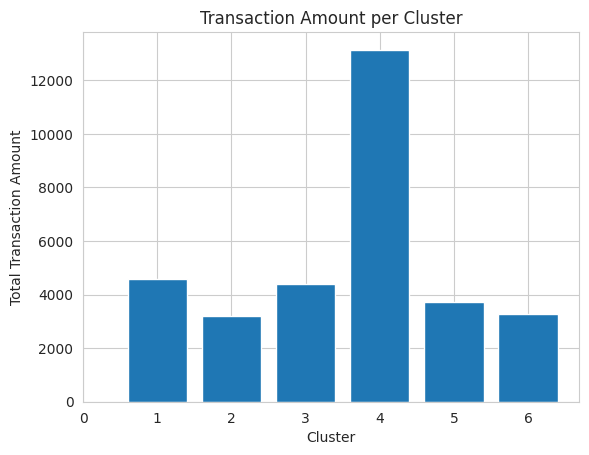

In [106]:
trans_amt = customers.groupby('CLUSTER')['total_trans_amount'].mean()
plt.bar(trans_amt.index, trans_amt.values,)
plt.xlabel('Cluster')
plt.ylabel('Total Transaction Amount')
plt.title('Transaction Amount per Cluster')
plt.xticks(range(0, 7))


([<matplotlib.axis.XTick at 0x7fc143c7d810>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

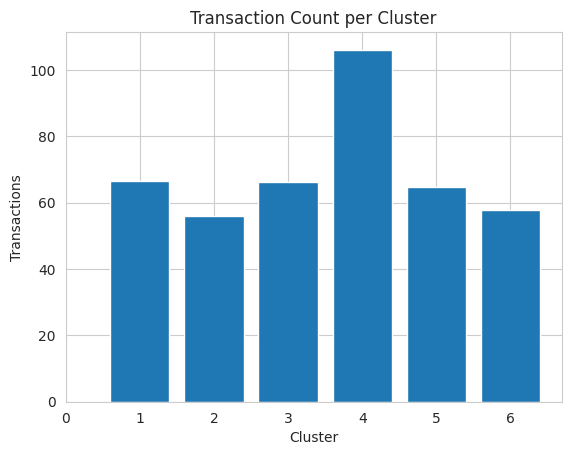

In [107]:
trans_count = customers.groupby('CLUSTER')['total_trans_count'].mean()
plt.bar(trans_count.index, trans_count.values,)
plt.xlabel('Cluster')
plt.ylabel('Transactions')
plt.title('Transaction Count per Cluster')
plt.xticks(range(0, 7))

([<matplotlib.axis.XTick at 0x7fc143cf4850>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

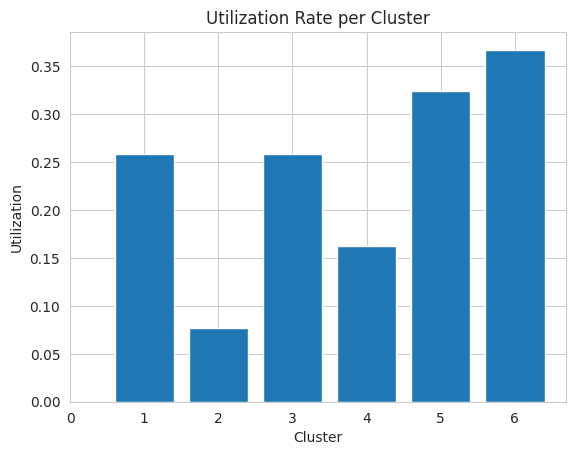

In [108]:
util_rat = customers.groupby('CLUSTER')['avg_utilization_ratio'].mean()
plt.bar(util_rat.index, util_rat.values,)
plt.xlabel('Cluster')
plt.ylabel('Utilization')
plt.title('Utilization Rate per Cluster')
plt.xticks(range(0, 7))

- The average age of the clusters is remarkably similar, mid-late forties. Reviewing the age distribution of the total dataset, it is clear that the segmentation hasn’t used age as a clustering feature and is mirroring the entire group. 
- Gender varies more. Cluster 2 is 95% male. Cluster 4 is 66% male. Clusters 5 and 6 are both nearly 70% female. 
- All the clusters have similar average numbers of dependents. These reflect the distribution of the total dataset. 
- The clusters have similar levels of education, on average they went to college. 
- Income is more varied. Clusters 1, 2 and 4 have a similar income level but Cluster 3 has nearly double the income of the other clusters. Clusters 5 and 6 are nearly a third lower in income versus 1, 2 and 4. 
- All the clusters have spent a similar time as customers. 
- All the clusters have similar amounts of contact with the company except 4 which looks to be nearly half the amount of contact. 
- All the clusters have similar levels of inactivity, although 4 seems a little lower which could be related back to contact. 
- Credit limit is more diverse. Clusters 5 and 6 have the lowest with \\$4000 - \\$5000 on average. Clusters 1 and 3 have just under \\$10,000. Cluster 4 has \\$15,000 while 3 is the outlier with $30K. 
- Transaction amounts are pretty similar, between \\$3000 and \\$5000 across the board, excluding cluster 4 which is over \$11,000. 
- Unsurprisingly, the number of transactions is similar to the total transaction amount with most clusters being similar except for 4 which looks to be nearly double the amount of each of the other clusters. 
- Average utilization rate outlines the amount of revolving credit a customer uses divided by the total credit available to them. On the face of it, the numbers are quite varied but in reality it looks to be the inverse of the credit limit. This means Clusters 1 and 3 sit just over 25%. Cluster 2 is about 7.5%, Cluster 4 is around 16% white 5 and 6 are more than 32%. 

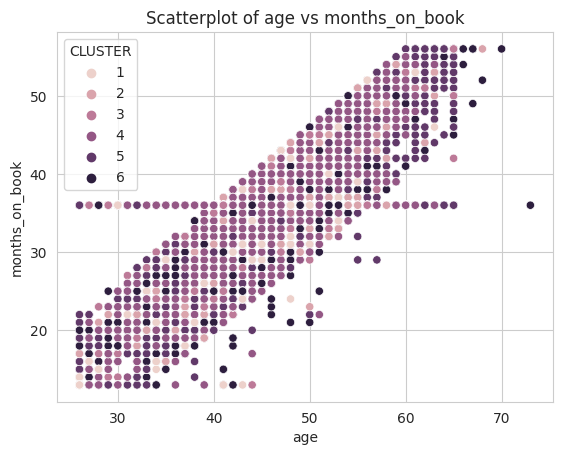

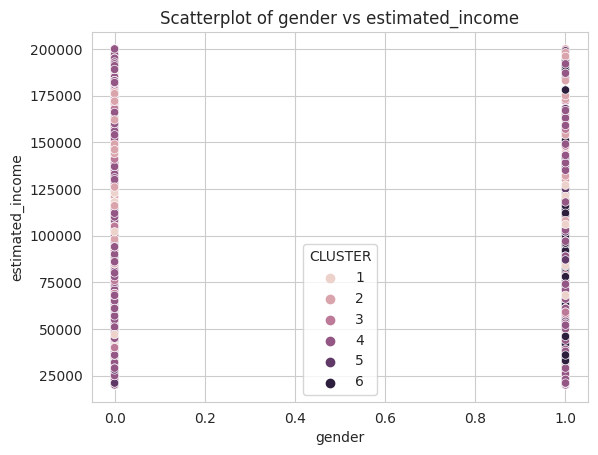

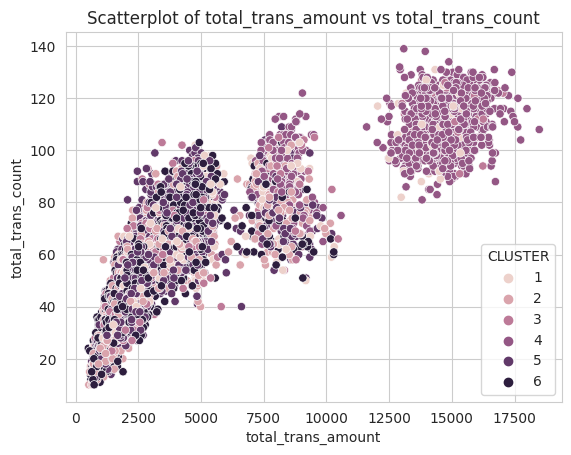

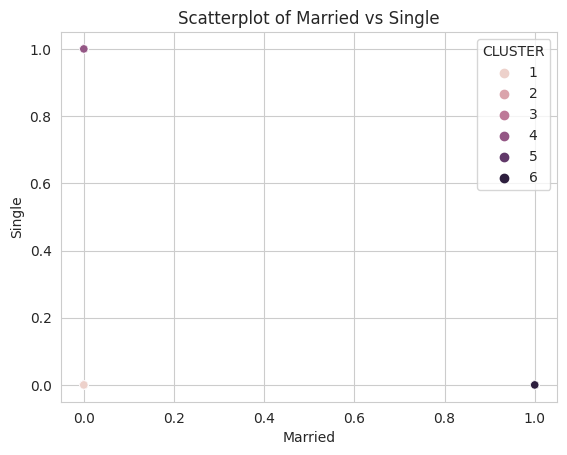

In [109]:
# Identifying strongly correlated pairs
pairs = []
for idx, row in corrs.iterrows():
    for col in corrs.columns:
        if idx != col and 0.6 <= abs(row[col]) < 1:
            if ((col, idx) not in pairs and (idx, col) not in pairs):
                pairs.append((idx, col))

                # Plotting
for (x, y) in pairs:
    sns.scatterplot(data=customers, x=x, y=y, hue='CLUSTER')
    plt.title(f'Scatterplot of {x} vs {y}')
    plt.xlabel(x)
    plt.ylabel(y)
    plt.show()

(array([0, 1, 2, 3, 4, 5]),
 [Text(0, 0, '1'),
  Text(1, 0, '2'),
  Text(2, 0, '3'),
  Text(3, 0, '4'),
  Text(4, 0, '5'),
  Text(5, 0, '6')])

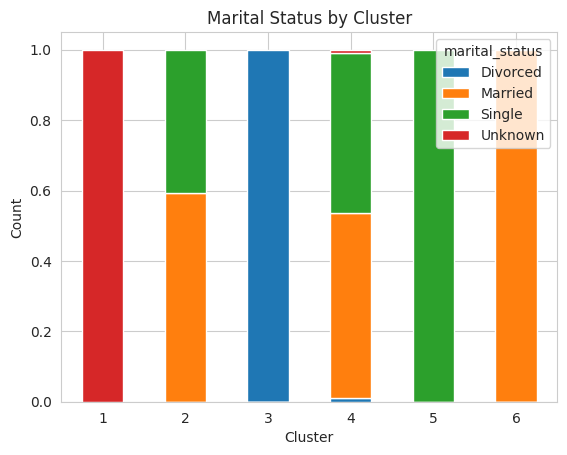

In [110]:
x_tab = pd.crosstab(index=customers['CLUSTER'],columns=customers['marital_status'],normalize='index')
x_tab.plot(kind='bar',stacked=True)
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.title('Marital Status by Cluster')
plt.xticks(rotation=0)  # keeps the x-axis labels horizontal

(array([0, 1, 2, 3, 4, 5]),
 [Text(0, 0, '1'),
  Text(1, 0, '2'),
  Text(2, 0, '3'),
  Text(3, 0, '4'),
  Text(4, 0, '5'),
  Text(5, 0, '6')])

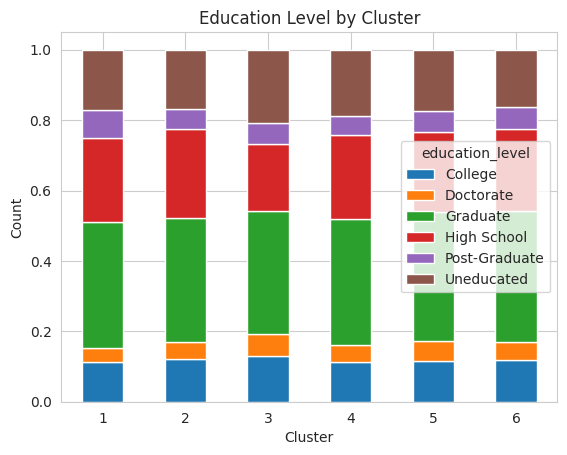

In [111]:
x_tab = pd.crosstab(index=customers['CLUSTER'],columns=customers['education_level'],normalize='index')
x_tab.plot(kind='bar',stacked=True)
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.title('Education Level by Cluster')
plt.xticks(rotation=0)  # keeps the x-axis labels horizontal

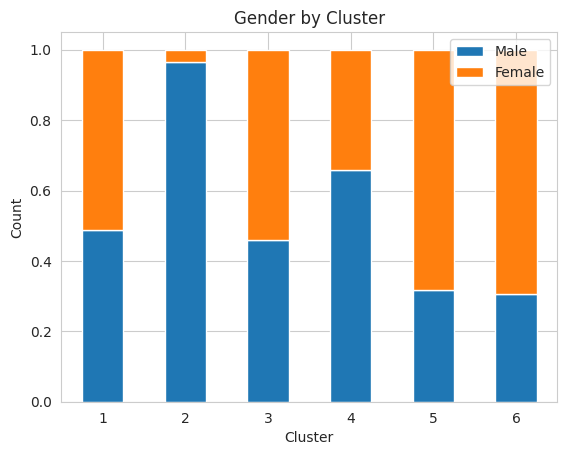

In [112]:
x_tab = pd.crosstab(index=customers['CLUSTER'],columns=customers['gender'],normalize='index')
x_tab.plot(kind='bar',stacked=True)
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.title('Gender by Cluster')
plt.xticks(rotation=0)  # keeps the x-axis labels horizontal
plt.legend(["Male", "Female"])

### Notable Segment Characteristics

#### Segment 1 - Run of the Mill
- Even gender split
- Average income
- Unknown marital status
- Middle of the road credit limit, transaction amount, transaction count and utilization rate. 

#### Segment 2 - Mega Males
- 95% male
- 60% married, 40% single
- High credit limit
- Low utilization 
- Very high income

#### Segment 3 - Split Differents
- Even gender split
- All divorced

#### Segment 4 - Silent Spenders
- 2/3 male
- Near even split between single and married
- Very high spend and transaction count
- Reasonable credit limit
- Less contact than then other Segments

#### Segment 5 - Single Spenders 
- Over 2/3 female
- completely single
- Lower income and credit limit
- Higher utilization rate

#### Segment 6 - Married & Harried
- Over 2/3 female
- completely married
- Lower income and credit limit
- Higher utilization rate

### Business Recommendations

Without knowing more of the particulars of this business, e.g. what features are good and bad as far as customers are concerned, we will make some recommendations based on assumptions. 

#### 1. Get more information about the Run of the Mills
It looks like this segment mostly exists as a catch all for unclassified marital status customers. If their marital status can be confirmed, they might be able to be placed in a more meaningful bracket and thus better targeted. 

#### 2. Activate the Mega Males
With reasonably high income, high credit limit but low utilization rate, the Mega Male segment is worth targeting to try and up their utilization. This could be through rewards or other loyalty programs. A separate tier or card could be developed to target them, potentially tapping into more of their emotional needs, e.g. demonstrate their position.  

#### 3. Build a relationship with the Split Differents
Are there initiatives that could be attractive to divorced people? Offering additional cards to new partners or shared cards for family expenses?

#### 4. Attract more Silent Spenders
With high spend and low contact, this is a very attractive group. with only 867 customers in that segment, there is definitely more room for growth. Can marketing campaigns be developed to recruit more of them?

#### 5. Develop special conditions for the Single Spenders
Create conditions that help the Single Spenders avoid missing payments and maxxing out their credit limit.

#### 6. Develop special conditions for the Married & Harried
Create conditions that help this segment avoid missing payments and maxxing out their credit limit.